# Introducción
Los sistemas de recomendación son uno de los modelos más interesantes en sistemas de ecommerce. Para este tipo de casos, se suelen usar modelos tradicionales o de DL como es el ALS, AutoEncoders. Sin embargo, este tipo de modelos suelen tener una serie de limitaciones sobre todo en plataformas de contenido dinámico como son Spotify, Youtube o Netflix. Es por ello, que los modelos de RL empiezan a coger peso en este tipo de casos de uso.

En este notebook, usaremos datos de la librería de Google para entornos de RL de sistemas de recomendación (recsim) y RLlib, una de las librerías más populares para el desarrollo de modelos de RL con un conjunto elevado de modelos.

**Objetivo de este notebook**

En este notebook usaremos el entorno InterestEvolutionRecSimEnv para evaluar los modelos de recsys para RL.

Probaremos los siguientes modelos para nuestro modelo online:
- Modelo baseline basado en comportamiento aleatorio
- Bandits
- SlateQ
- DQN

Por último, guardaremos los resultados de los modelos utilizando tune.run para poder posteriormente hacer modelos offline.

**Siguientes pasos**


Luego, en otros notebooks, se estudiarán los siguientes puntos:
- Probar el entorno LongTermSatisfactionRecSimEnv y Modificar el mismo para poder obtener la satisfacción del cliente y hacer que el efecto del mismo sea más potente. Analizaremos los resultados de los modelos descritos anteriormente modificando esto.
- Generar modelos offline a partir de datos extraídos del environment de InterestEvolutionRecSimEnv
- Puesta en productivo del modelo.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:


# Librerías estandar
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
import os
import itertools
import random
import glob


# librerias para RL
import ray
from ray import tune
## environment
from ray.rllib.examples.env.recommender_system_envs_with_recsim import LongTermSatisfactionRecSimEnv, InterestEvolutionRecSimEnv

## agentes
from ray.rllib.algorithms.slateq import SlateQ as SlateQTrainer
from ray.rllib.algorithms.bandit import BanditLinUCB as BanditLinUCBTrainer
from ray.rllib.algorithms.dqn import DQN as DQNTrainer


## configs
from ray.rllib.algorithms.bandit import BanditLinTSConfig
from ray.rllib.algorithms.slateq import  SlateQConfig
from ray.rllib.algorithms.dqn import DQNConfig

## default config de los agentes
from ray.rllib.algorithms.bandit.bandit import DEFAULT_CONFIG as BANDIT_DEFAULT_CONFIG 
from ray.rllib.algorithms.slateq.slateq import DEFAULT_CONFIG as SLATEQ_DEFAULT_CONFIG 

from ray.rllib.algorithms.dqn.dqn import DEFAULT_CONFIG as DQN_DEFAULT_CONFIG

C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
C:\Users\Paul\AppData\Roa

In [3]:
# cargamos las funciones que hemos guardado dentro de la carpeta src
# nos permite compartir funciones en diferentes notebooks
import sys
sys.path.append('../src')
from data.env import LTSWrapperEnvDefault
from models.rlmodels import run_random_walk_episode, run_rlmodel_episode, run_simulation, run_one_single_episode
from models.rlmodelsanalysis import rllib_analysis_to_df, check_prob_len, get_reward_stats, append_reward_stats
from visualization.visualize import plot_rewards_timestamp
from utils.docs import get_json_files

# Environment
A continuación vemos como es el entorno sobre el que vamos a entrenar nuestro agente

In [4]:
SEED = 0

## configuración del entorno: 20 posibles candidatos del que seleccionaremos 2
# mantendremos esta configuración para los demás agentes también
NUM_CANDIDATES = 20
SLATE_SIZE = 2
#REGISTER_ENV_NAME = "env_lts"
REGISTER_ENV_NAME = "env_ie"

In [5]:
np.random.seed(SEED)

env_config = {
  'num_candidates': NUM_CANDIDATES,  # numero de videos que tenemos para elegir
  'slate_size': SLATE_SIZE,  # numero de documentos que voy a seleccionar entre los candidatos
  'resample_documents': False, # si resampleamos los documentos en cada episodio
  'seed': SEED,
  "convert_to_discrete_action_space": True,  # Convierte a un espacio discreto
  # "wrap_for_bandits": True,   # permite que el agente sea un bandits, cambiando los diccionarios (item -> doc)
  }

# inicializamos el entorno
#env_lts = LTSWrapperEnvDefault(LongTermSatisfactionRecSimEnv(env_config))
#env_lts = LongTermSatisfactionRecSimEnv(env_config)
env_lts = InterestEvolutionRecSimEnv(env_config)
#vemos una observación obtenida por el entorno
obs = env_lts.reset()
obs


OrderedDict([('user',
              array([ 0.9572367 ,  0.59831715, -0.07704128,  0.56105834, -0.76345116,
                      0.27984205, -0.71329343,  0.88933784,  0.04369664, -0.17067613,
                     -0.47088876,  0.5484674 , -0.08769934,  0.1368679 , -0.9624204 ,
                      0.23527099,  0.22419144,  0.23386799,  0.8874962 ,  0.3636406 ],
                    dtype=float32)),
             ('doc',
              {'0': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
                      0., 0., 0.], dtype=float32),
               '1': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0.], dtype=float32),
               '2': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0.], dtype=float32),
               '3': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0.], dtype=f

In [6]:
# en este caso hemos convertido el espacio de acciones a un espacio discreto
# y tiene el tamapo slate_size=2;num_candidates=20 -> MultiDiscrete([20, 20]) -> Discrete(400)  (20x20)
env_lts.action_space

Discrete(400)

Lo que obtenemos en la celda anterior es la información de usuario, documentos e interacción entre estos dos.

- El usuario representa las features observables del usuario con el mismo número de documentos a recomendar.
- En la key de documentos podemos encontrar el NUM_CANDIDATES posibles documentos a recomendar. Cada uno de ellos contiene un número que define el feature vector del documento. En la respuesta tenermos las acciones realizadas por el usuario. 
- La respuesta indica la respuesta del usuario a las últimas recomendaciones de los slots (user response). 


A continuación modificamos la configuración den entorno y lo guardamos para que luego pueda ser utilizado por el Bandits.

In [7]:

env_config["wrap_for_bandits"] = True

# inicializamos el entorno
env_lts = InterestEvolutionRecSimEnv(env_config)
#env_lts = LTSWrapperEnvDefault(LongTermSatisfactionRecSimEnv(env_config))
#env_lts = LongTermSatisfactionRecSimEnv(env_config)
# lo registramos para luego poder ser utilizado en otros agentes
tune.register_env(REGISTER_ENV_NAME,lambda env_config:InterestEvolutionRecSimEnv(env_config))
#tune.register_env(REGISTER_ENV_NAME, lambda env_config: LTSWrapperEnvDefault(LongTermSatisfactionRecSimEnv(env_config)))
#tune.register_env(REGISTER_ENV_NAME,lambda env_config:LongTermSatisfactionRecSimEnv(env_config))


# Modelo Baseline aleatorio 

In [8]:
# ejecutamos un único episodio
run_random_walk_episode(env_lts)

164.0

In [9]:
NUM_EPISODES = 2000
MODEL_NAME = "random"
# simulacion de una serie de episodios
rewards,time_spend = run_simulation(env_lts, func= run_random_walk_episode, num_episodes=NUM_EPISODES)
mean_reward_all_sim_random_walk = np.mean(rewards)

100%|██████████| 2000/2000 [00:49<00:00, 40.24it/s]


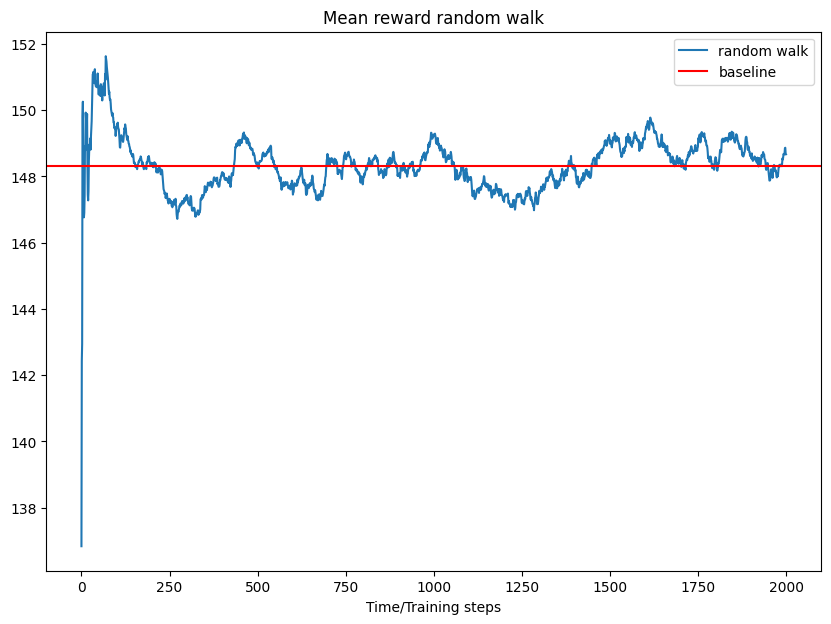

In [10]:
plot_rewards_timestamp(rewards, reward_mean_baseline=mean_reward_all_sim_random_walk, model_name="random walk")

Usaremos el promedio obtenido del modelo aleatorio para compararlo con otros modelos

In [11]:
results_df = append_reward_stats(rewards,MODEL_NAME,time_spend=time_spend,num_episodes = NUM_EPISODES)
results_df

,model_name,n_episodes,mean_reward,std_reward,min_reward,max_reward,time_spend
0,random,2000,148.308959,12.011733,116.579578,208.0,49.702252


# Bandits

In [12]:
# vemos la configuración por defecto actual de bandits
print(f"Bandit's default config is:")
pprint(BANDIT_DEFAULT_CONFIG)


Bandit's default config is:
{'_disable_action_flattening': False,
 '_disable_execution_plan_api': True,
 '_disable_preprocessor_api': False,
 '_fake_gpus': False,
 '_tf_policy_handles_more_than_one_loss': False,
 'action_space': None,
 'actions_in_input_normalized': False,
 'always_attach_evaluation_results': False,
 'batch_mode': 'truncate_episodes',
 'buffer_size': -1,
 'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
 'clip_actions': False,
 'clip_rewards': None,
 'collect_metrics_timeout': -1,
 'compress_observations': False,
 'create_env_on_driver': False,
 'custom_eval_function': None,
 'custom_resources_per_worker': {},
 'disable_env_checking': False,
 'eager_max_retraces': 20,
 'eager_tracing': False,
 'enable_connectors': False,
 'enable_tf1_exec_eagerly': False,
 'env': None,
 'env_config': {},
 'env_task_fn': None,
 'evaluation_config': {},
 'evaluation_duration': 10,
 'evaluation_duration_unit': 'episodes',
 'evaluation_interval': None,
 'evaluation_n


Es necesario configurarla para nuestro caso de uso

In [13]:
MODEL_NAME = "banditsLinUCB"
SMOTHING_WIN = 200
NUM_EPISODES = 2000
env_bandit_config = BANDIT_DEFAULT_CONFIG

env_bandit_config.update({
    "env": REGISTER_ENV_NAME, # nombre del entorno que hemos registrado
    "env_config": env_config, # configuración del entorno
    "seed": SEED, # seed para el trainer

    "timesteps_per_iteration": 1, # genera un dict de resultados cada time step
    "metrics_num_episodes_for_smoothing": SMOTHING_WIN, # muestra los rewards suavizados con la media cada 200 episodios
})
# creamos el trainer con esta configuración
bandit_trainer = BanditLinUCBTrainer(config=env_bandit_config)
bandit_trainer

2022-09-12 22:36:11,990	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.algorithms.bandit.bandit.DEFAULT_CONFIG` has been deprecated. Use `ray.rllib.algorithms.bandit.bandit.BanditLin[UCB|TS]Config(...)` instead. This will raise an error in the future!
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\rllib\utils\debug\deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):
2022-09-12 22:36:11,993	WARNING deprecation.py:47 -- DeprecationWarning: `timesteps_per_iteration` has been deprecated. Use ``min_sample_timesteps_per_iteration` OR `min_train_timesteps_per_iteration`` instead. This will raise an error in the future!
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required objec

BanditLinUCB

In [14]:
#ejecutamos la simulacion
rewards,time_spend = run_simulation(bandit_trainer,agg_func="mean",num_episodes=NUM_EPISODES)

100%|██████████| 2000/2000 [00:41<00:00, 48.59it/s]


../src\visualization\visualize.py:13: RuntimeWarning: Mean of empty slice
  y = [np.nanmean(rewards[max(i - smothing_win, 0):i + 1]) for i in range(start_at, len(rewards))]


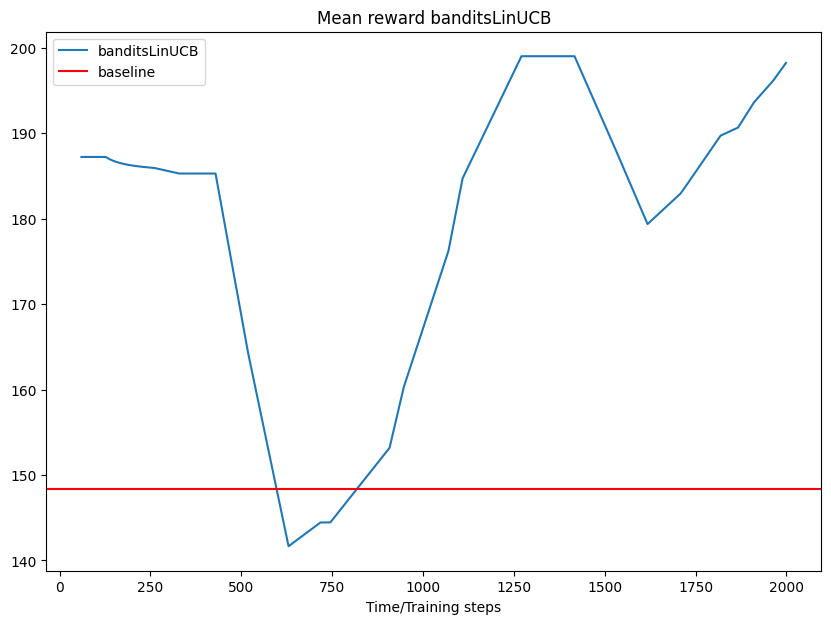

In [15]:
plot_rewards_timestamp(rewards, reward_mean_baseline=mean_reward_all_sim_random_walk, model_name=MODEL_NAME)

In [16]:
results_df = append_reward_stats(rewards,MODEL_NAME,time_spend=time_spend,df = results_df,num_episodes = NUM_EPISODES)
results_df

,model_name,n_episodes,mean_reward,std_reward,min_reward,max_reward,time_spend
0,random,2000,148.308959,12.011733,116.579578,208.000000,49.702252
1,banditsLinUCB,2000,179.134420,19.895119,138.094640,203.390931,41.159141


Si nos ponemos a evaluar cuales están siendo las recomendaciones del bandits, vemos que existe un problema y es que siempre recomienda productos con un feature valor igual a 0 cuando el máximo es 1. Está siempre recomendando la misma tipología de productos en función de su feature vector.

In [17]:
run_one_single_episode(env_lts,bandit_trainer)

action's feature value=0.0; max-feature=1.0; min-feature=0.0
action's feature value=0.0; max-feature=1.0; min-feature=0.0
action's feature value=0.0; max-feature=1.0; min-feature=0.0
action's feature value=0.0; max-feature=1.0; min-feature=0.0
action's feature value=0.0; max-feature=1.0; min-feature=0.0
action's feature value=0.0; max-feature=1.0; min-feature=0.0
action's feature value=0.0; max-feature=1.0; min-feature=0.0
action's feature value=0.0; max-feature=1.0; min-feature=0.0
action's feature value=0.0; max-feature=1.0; min-feature=0.0
action's feature value=0.0; max-feature=1.0; min-feature=0.0
action's feature value=0.0; max-feature=1.0; min-feature=0.0
action's feature value=0.0; max-feature=1.0; min-feature=0.0
action's feature value=0.0; max-feature=1.0; min-feature=0.0
action's feature value=0.0; max-feature=1.0; min-feature=0.0
action's feature value=0.0; max-feature=1.0; min-feature=0.0
action's feature value=0.0; max-feature=1.0; min-feature=0.0
action's feature value=0

# DQN
A continuación probamos un modelo DQN. Guardaremos los datos del output del mismo para luego utilizar offline RL.

In [18]:
SMOTHING_WIN = 250
MODEL_NAME = "DQN"
NUM_EPISODES = 1000
# Offline input (JSON) file:
#OUTPUT_DIR = "..\\data\\processed\\offline_rl\\longinterest_recsim"
#if not os.path.exists(OUTPUT_DIR):
#    os.makedirs(OUTPUT_DIR)

env_dqn_config = DQN_DEFAULT_CONFIG

env_dqn_config.update({
    "env": REGISTER_ENV_NAME,
    "env_config": env_config,
    "seed": SEED, # seed para el trainer

    "timesteps_per_iteration": 100, # genera un dict de resultados cada time step
    "metrics_num_episodes_for_smoothing": SMOTHING_WIN, # muestra los rewards suavizados con la media cada 200 episodios
 #   "output": OUTPUT_DIR, # añadimos esto para luego hacer offline RL
 #   "output_config": {
 #       "format": "json",  # json o parquet
 #       "store_infos" : True, # guardar la info
 #        "max_num_samples_per_file": 500_000,
 #   },
    "exploration_config": {
            "type": "SoftQ",
            "temperature": 1.0,
        },
})
# creamos el trainer con esta configuración
dqn_trainer = DQNTrainer(config=env_dqn_config)
dqn_trainer

2022-09-12 22:37:01,548	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.algorithms.dqn.dqn.DEFAULT_CONFIG` has been deprecated. Use `ray.rllib.algorithms.dqn.dqn.DQNConfig(...)` instead. This will raise an error in the future!
2022-09-12 22:37:01,550	WARNING deprecation.py:47 -- DeprecationWarning: `timesteps_per_iteration` has been deprecated. Use ``min_sample_timesteps_per_iteration` OR `min_train_timesteps_per_iteration`` instead. This will raise an error in the future!
2022-09-12 22:37:01,550	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (http

DQN

In [19]:
rewards,time_spend = run_simulation(dqn_trainer,agg_func="mean",num_episodes =NUM_EPISODES)

  0%|          | 0/1000 [00:00<?, ?it/s]2022-09-12 22:37:03,377	WARNING deprecation.py:47 -- DeprecationWarning: `ReplayBuffer.add_batch()` has been deprecated. Use `ReplayBuffer.add()` instead. This will raise an error in the future!
2022-09-12 22:37:03,386	WARNING multi_agent_prioritized_replay_buffer.py:220 -- Adding batches with column `weights` to this buffer while providing weights as a call argument to the add method results in the column being overwritten.
100%|██████████| 1000/1000 [17:14<00:00,  1.03s/it]


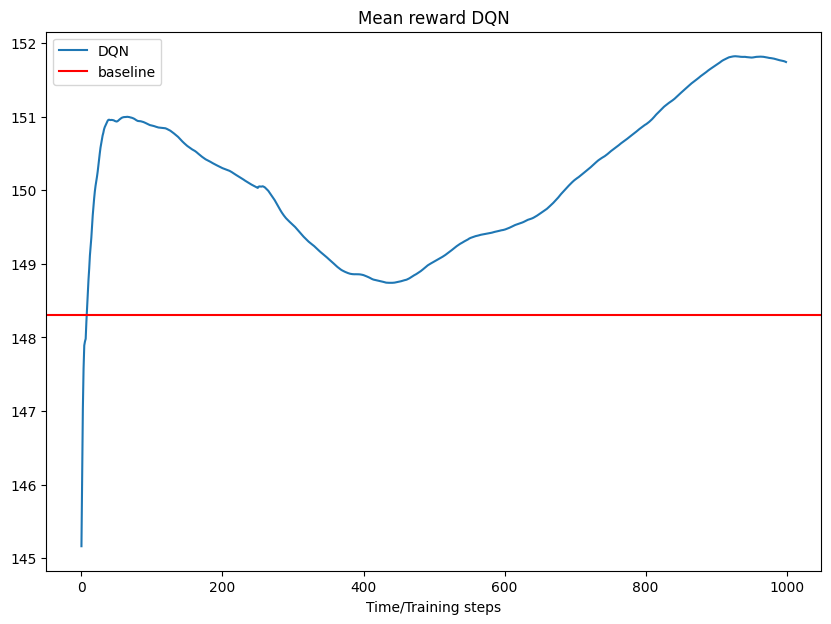

In [20]:
plot_rewards_timestamp(rewards=rewards,reward_mean_baseline=mean_reward_all_sim_random_walk, model_name=MODEL_NAME,smothing_win=SMOTHING_WIN)

In [25]:
results_df = append_reward_stats(rewards,MODEL_NAME,time_spend=time_spend,df = results_df,num_episodes = NUM_EPISODES)
results_df

,model_name,n_episodes,mean_reward,std_reward,min_reward,max_reward,time_spend
0,random,2000,148.308959,12.011733,116.579578,208.000000,49.702252
1,banditsLinUCB,2000,179.134420,19.895119,138.094640,203.390931,41.159141
2,DQN,1000,150.329524,1.318501,145.165087,152.719832,1034.128243


# SlateQ
A continuación ejecutamos el modelo SlateQ. Primero vemos todos los parámetros configurables del mismo y luego modificamos aquellos que nos interesa para nuestro modelo.

Ejecutamos el modelo de SlateQ

In [26]:
SMOTHING_WIN = 200
MODEL_NAME = "slateQ"
NUM_EPISODES = 150
slate_env_config =  {
        "num_candidates": NUM_CANDIDATES, # obtenemos un caso MultiDiscrete([20,20]) debido a que tenemos 2 slate_size y 20 posibles documentos
        "slate_size": SLATE_SIZE,
        "resample_documents": True,
        "wrap_for_bandits": False,  # Necesario para que el agente sea un slateq
        "convert_to_discrete_action_space": False,  # En slateq tenemos un espacio múltiple
    }
slateq_config = SLATEQ_DEFAULT_CONFIG
slateq_config_update = {
    "env": REGISTER_ENV_NAME,
    "env_config":slate_env_config,
    # Setup exploratory behavior: Implemented as "epsilon greedy" strategy:
    # Act randomly `e` percent of the time; `e` gets reduced from 1.0 to almost 0.0 over
    # the course of `epsilon_timesteps`.
    "exploration_config": {
      #  "type": "SlateEpsilonGreedy", #SlateSoftQ or SlateEpsilonGreedy
        "warmup_timesteps": 20000,  # valor por defecto
        #"epsilon_timesteps": 40000 #tune.grid_search([40000, 2000, 3000]),  # default: 250000
    },
    "learning_starts": 20000,  # valor por defecto
    "target_network_update_freq": 3200,
    #'framework': 'torch', #necesario para slateSoftQ

    # Report rewards as smoothed mean over this many episodes.
    "metrics_num_episodes_for_smoothing": SMOTHING_WIN,
    
    
   
}

SLATEQ_DEFAULT_CONFIG.update(slateq_config_update)

# Instantiate the Trainer object using the exact same config as in our Bandit experiment above.
slateq_trainer = SlateQTrainer(config=slateq_config_update)
slateq_trainer

2022-09-12 22:57:07,202	WARNING deprecation.py:47 -- DeprecationWarning: `config['learning_starts']` has been deprecated. config['replay_buffer_config']['learning_starts'] This will raise an error in the future!
2022-09-12 22:57:07,203	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!


Instructions for updating:
Use fn_output_signature instead


C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(
Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
2022-09-12 22:57:21,437	INFO trainable.py:160 -- Trainable.setup took 14.236 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


SlateQ

In [27]:
rewards,time_spend = run_simulation(slateq_trainer,agg_func="mean",num_episodes =NUM_EPISODES)

100%|██████████| 150/150 [46:10<00:00, 18.47s/it]


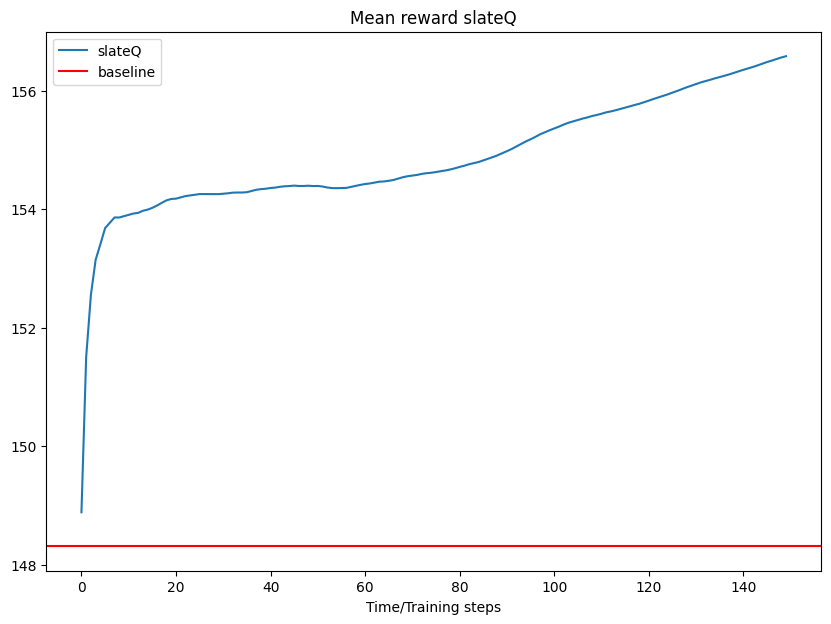

In [28]:
plot_rewards_timestamp(rewards=rewards,reward_mean_baseline=mean_reward_all_sim_random_walk, model_name=MODEL_NAME,smothing_win=SMOTHING_WIN)

In [31]:
env_lts_slate = InterestEvolutionRecSimEnv(slate_env_config)

run_one_single_episode(env_lts_slate,slateq_trainer,model="slateq")

action's feature value=1.0; max-feature=0.0; min-feature=0.0
action's feature value=0.0; max-feature=0.0; min-feature=0.0
action's feature value=0.0; max-feature=0.0; min-feature=0.0
action's feature value=0.0; max-feature=0.0; min-feature=0.0
action's feature value=0.0; max-feature=0.0; min-feature=0.0
action's feature value=0.0; max-feature=0.0; min-feature=0.0
action's feature value=0.0; max-feature=0.0; min-feature=0.0
action's feature value=0.0; max-feature=0.0; min-feature=0.0
action's feature value=0.0; max-feature=0.0; min-feature=0.0
action's feature value=0.0; max-feature=0.0; min-feature=0.0
action's feature value=0.0; max-feature=0.0; min-feature=0.0
action's feature value=1.0; max-feature=0.0; min-feature=0.0
action's feature value=0.0; max-feature=1.0; min-feature=0.0
action's feature value=0.0; max-feature=0.0; min-feature=0.0
action's feature value=0.0; max-feature=0.0; min-feature=0.0
action's feature value=0.0; max-feature=0.0; min-feature=0.0
action's feature value=0

In [24]:
results_df = append_reward_stats(rewards,MODEL_NAME,time_spend=time_spend,df = results_df,num_episodes = NUM_EPISODES)
results_df

,model_name,n_episodes,mean_reward,std_reward,min_reward,max_reward,time_spend
0,random,2000,149.155525,12.111321,118.231866,201.112473,49.251402
1,banditsLinUCB,2000,150.002118,9.810029,122.664931,165.272154,37.857434
2,DQN,1000,150.450176,1.456386,141.090185,153.023201,1033.549553
3,slateQ,150,156.839412,1.862154,153.308678,160.658130,2832.659636


In [ ]:
results_df.to_csv("../models/online_rl/ir/results_ir.csv")

# Generación de un fichero offline
Para la generación de un fichero que nos permita probar un algoritmo offline, es necesario tener de cada acción una probabilidad asociada al mismo. La estrategia greedy no permite obtener eso (las probabilidades devueltas son 1), es por ello que es necesario cambiarla a SoftQ. Para esto, ejecutamos el modelo usando el tune.run para hacer un análisis del mismo y guardamos checkpoints del mismo.
El modelo utilizado en este caso ha sido el DQN. Es posible con SlateQ también utilizar una estrategia SlateSoftQ pero la implementación en la librería es incorrecta. Se ha probado y los resultados no son correctos.

## DQN

In [12]:
SMOTHING_WIN = 250
MODEL_NAME = "dqn_saver"
# Offline input (JSON) file:
#OUTPUT_DIR = "..\\data\\processed\\offline_rl\\longinterest_recsim\dqn"
OUTPUT_DIR = "data"

#if not os.path.exists(OUTPUT_DIR):
#    os.makedirs(OUTPUT_DIR)

env_dqn_config_saver = DQN_DEFAULT_CONFIG

env_dqn_config_saver_update ={
    "env": REGISTER_ENV_NAME,
    "env_config": env_config,
    "seed": SEED, # seed para el trainer

    "timesteps_per_iteration": 1, # genera un dict de resultados cada time step
    "metrics_num_episodes_for_smoothing": SMOTHING_WIN, # muestra los rewards suavizados con la media cada 200 episodios
    "output": OUTPUT_DIR, # añadimos esto para luego hacer offline RL
    "output_config": {
        "format": "json",  # json o parquet
        "store_infos" : True, # guardar la info
         #"max_num_samples_per_file": 500_000,
          "output_max_file_size" : 256 * 1024 * 1024 # 256 Mb,

         
    },
    "exploration_config": {
            "type": "SoftQ",
            "temperature": 1.0,
        },
}

env_dqn_config_saver.update(env_dqn_config_saver_update)
# creamos el trainer con esta configuración
dqn_trainer_saver = DQNTrainer(config=env_dqn_config_saver)
dqn_trainer_saver

2022-09-12 22:34:12,111	WARNING deprecation.py:47 -- DeprecationWarning: `timesteps_per_iteration` has been deprecated. Use ``min_sample_timesteps_per_iteration` OR `min_train_timesteps_per_iteration`` instead. This will raise an error in the future!
2022-09-12 22:34:12,112	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(


DQN

Generamos un modelo usando tune. 

In [26]:
# definimos las características para el stop del modelo
TRAINING_ITERATION= 50
stop = {
    "training_iteration": TRAINING_ITERATION,
    "episode_reward_mean": 163.0,
}
analysis = tune.run(
        DQNTrainer,
        config=env_dqn_config_saver_update,
        stop=stop,
        checkpoint_freq=TRAINING_ITERATION,  # checkpoint al final y cada X iteraciones
        checkpoint_at_end=True,
        verbose = 2)

Trial name,status,loc,iter,total time (s),ts,reward,num_recreated_wor...,episode_reward_max,episode_reward_min
DQN_env_ie_5e8d7_00000,TERMINATED,127.0.0.1:26284,50,50.6467,8184,151.344,0,186.57,126.514


C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\util\placement_group.py:78: DeprecationWarning: placement_group parameter is deprecated. Use scheduling_strategy=PlacementGroupSchedulingStrategy(...) instead, see the usage at https://docs.ray.io/en/releases-2.0.0/ray-core/package-ref.html#ray-remote.
  return bundle_reservation_check.options(
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\actor.py:637: DeprecationWarning: placement_group parameter is deprecated. Use scheduling_strategy=PlacementGroupSchedulingStrategy(...) instead, see the usage at https://docs.ray.io/en/releases-2.0.0/ray-core/package-ref.html#ray-remote.
  return actor_cls._remote(args=args, kwargs=kwargs, **updated_options)
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\actor.py:637: DeprecationWarning: placement_group_bundle_index parameter is deprecated. Use scheduling_strategy=PlacementGroupSchedulingStrategy(...) instead, see the usage at https://docs.ray.io/en/re

Trial DQN_env_ie_5e8d7_00000 reported custom_metrics={},episode_media={},num_recreated_workers=0,info={'learner': {}, 'num_env_steps_sampled': 248, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 248, 'num_agent_steps_trained': 0},sampler_results={'episode_reward_max': 152.0, 'episode_reward_min': 139.22727372248326, 'episode_reward_mean': 145.61363686124162, 'episode_len_mean': 95.5, 'episode_media': {}, 'episodes_this_iter': 2, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [152.0, 139.22727372248326], 'episode_lengths': [101, 90]}, 'sampler_perf': {'mean_raw_obs_processing_ms': 1.7658294922855486, 'mean_inference_ms': 0.9936089496535949, 'mean_action_processing_ms': 0.05728844179207063, 'mean_env_wait_ms': 0.3969334215524206, 'mean_env_render_ms': 0.0}, 'num_faulty_episodes': 0},episode_reward_max=152.0,episode_reward_min=139.22727372248326,episode_reward_mean=145.61363686124162,episode_len_me

(DQN pid=26284) 2022-09-01 17:40:25,585	WARNING deprecation.py:47 -- DeprecationWarning: `concat_samples` has been deprecated. Use `concat_samples() from rllib.policy.sample_batch` instead. This will raise an error in the future!


Trial DQN_env_ie_5e8d7_00000 reported custom_metrics={},episode_media={},num_recreated_workers=0,info={'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'mean_q': 2.3769562, 'min_q': 0.6552876, 'max_q': 4.2418423, 'mean_td_error': 0.18359494, 'model': {}}, 'td_error': array([ 3.60453   , -2.0241818 ,  4.173481  ,  1.9542426 ,  2.50436   ,
        1.262067  , -0.77217865, -0.72977376,  3.3590736 , -1.0990181 ,
       -1.4090872 , -2.5158706 , -2.1970377 , -3.1996887 , -1.4419422 ,
        1.5682647 ,  2.808147  , -1.3550653 ,  0.5869264 , -0.05604076,
        1.6298996 ,  0.7839201 , -0.12302971, -3.3807304 ,  2.2930102 ,
       -1.7023563 ,  3.2156897 , -1.4958682 , -1.9403212 ,  1.1053264 ,
       -1.5856886 ,  2.053979  ], dtype=float32), 'custom_metrics': {}, 'num_agent_steps_trained': 32.0}}, 'num_env_steps_sampled': 1368, 'num_env_steps_trained': 2976, 'num_agent_steps_sampled': 1368, 'num_agent_steps_trained': 2976, 'last_target_update_ts': 1000, '

2022-09-01 17:41:14,907	INFO tune.py:758 -- Total run time: 61.64 seconds (60.88 seconds for the tuning loop).


Analizamos el modelo y sus resultados

In [27]:
analysis.trial_dataframes.keys()

dict_keys(['C:\\Users\\Paul\\ray_results\\DQN_2022-09-01_17-40-13\\DQN_env_ie_5e8d7_00000_0_2022-09-01_17-40-13'])

In [28]:
frame = rllib_analysis_to_df(analysis)
frame.head()

,num_recreated_workers,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_faulty_episodes,num_healthy_workers,num_agent_steps_sampled,num_agent_steps_trained,...,perf/cpu_util_percent,perf/ram_util_percent,sampler_results/hist_stats/episode_reward,sampler_results/hist_stats/episode_lengths,sampler_results/sampler_perf/mean_raw_obs_processing_ms,sampler_results/sampler_perf/mean_inference_ms,sampler_results/sampler_perf/mean_action_processing_ms,sampler_results/sampler_perf/mean_env_wait_ms,sampler_results/sampler_perf/mean_env_render_ms,logdir
0,0,152.00000,139.227274,145.613637,95.500000,2,0,0,248,0,...,26.30,42.0,"[152.0, 139.22727372248326]","[101, 90]",1.765829,0.993609,0.057288,0.396933,0.0,C:\Users\Paul\ray_results\DQN_2022-09-01_17-40...
1,0,167.50476,132.043281,148.092125,88.666667,4,0,0,564,0,...,25.90,42.0,"[152.0, 139.22727372248326, 132.04328115221355...","[101, 90, 102, 73, 95, 71]",1.536078,0.917809,0.055193,0.411495,0.0,C:\Users\Paul\ray_results\DQN_2022-09-01_17-40...
2,0,167.50476,132.043281,150.221298,87.800000,4,0,0,884,0,...,22.85,42.1,"[152.0, 139.22727372248326, 132.04328115221355...","[101, 90, 102, 73, 95, 71, 74, 91, 105, 76]",1.457742,0.888013,0.054381,0.411049,0.0,C:\Users\Paul\ray_results\DQN_2022-09-01_17-40...
3,0,167.50476,132.043281,150.135961,85.166667,2,0,0,1056,480,...,27.60,42.1,"[152.0, 139.22727372248326, 132.04328115221355...","[101, 90, 102, 73, 95, 71, 74, 91, 105, 76, 60...",1.434035,0.878594,0.054620,0.412040,0.0,C:\Users\Paul\ray_results\DQN_2022-09-01_17-40...
4,0,167.50476,132.043281,150.311416,84.142857,2,0,0,1212,1728,...,22.95,42.2,"[152.0, 139.22727372248326, 132.04328115221355...","[101, 90, 102, 73, 95, 71, 74, 91, 105, 76, 60...",1.413540,0.871645,0.055179,0.412250,0.0,C:\Users\Paul\ray_results\DQN_2022-09-01_17-40...


Vemos las variables del análisis. 

In [29]:
frame.columns

Index(['num_recreated_workers', 'episode_reward_max', 'episode_reward_min',
       'episode_reward_mean', 'episode_len_mean', 'episodes_this_iter',
       'num_faulty_episodes', 'num_healthy_workers', 'num_agent_steps_sampled',
       'num_agent_steps_trained', 'num_env_steps_sampled',
       'num_env_steps_trained', 'num_env_steps_sampled_this_iter',
       'num_env_steps_trained_this_iter', 'timesteps_total',
       'num_steps_trained_this_iter', 'agent_timesteps_total', 'done',
       'episodes_total', 'training_iteration', 'trial_id', 'experiment_id',
       'date', 'timestamp', 'time_this_iter_s', 'time_total_s', 'pid',
       'hostname', 'node_ip', 'time_since_restore', 'timesteps_since_restore',
       'iterations_since_restore', 'warmup_time', 'info/num_env_steps_sampled',
       'info/num_env_steps_trained', 'info/num_agent_steps_sampled',
       'info/num_agent_steps_trained', 'sampler_results/episode_reward_max',
       'sampler_results/episode_reward_min',
       'sampler_r

In [30]:
output_csv = os.path.join(frame.logdir.iloc[0],"analysis_results_dataframe.pickle")
frame.to_pickle(output_csv)

Analizamos el último fichero generado para ver que el formato cuadra con el necesario para generar modelos offline.

In [9]:
json_output_file = get_json_files(os.path.join(frame.logdir.iloc[0],OUTPUT_DIR))[-1]
print(json_output_file)
df = pd.read_json(json_output_file,lines=True)
df.head()

C:\Users\Paul\ray_results\DQN_2022-09-01_17-40-13\DQN_env_ie_5e8d7_00000_0_2022-09-01_17-40-13\data\output-2022-09-01_17-40-45_worker-0_1.json


,type,obs,new_obs,actions,prev_actions,rewards,prev_rewards,dones,infos,t,eps_id,unroll_id,agent_index,q_values,action_dist_inputs,action_logp,action_prob,weights
0,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[258, 58, 374, 55]","[364, 258, 58, 374]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[47, 48, 49, 50]","[1109658755, 1109658755, 1109658755, 1109658755]","[1027, 1027, 1027, 1027]","[0, 0, 0, 0]","[[15.685279846191406, 15.421998977661133, 14.0...","[[15.685279846191406, 15.421998977661133, 14.0...","[-7.300140380859375, -4.897860527038574, -5.33...","[0.000675443967338, 0.007462531793862001, 0.00...","[1.0, 1.0, 1.0, 1.0]"
1,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[226, 48, 197, 55]","[55, 226, 48, 197]","[4.0, 0.0, 4.0, 4.0]","[0.0, 4.0, 0.0, 4.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[51, 52, 53, 54]","[1109658755, 1109658755, 1109658755, 1109658755]","[1028, 1028, 1028, 1028]","[0, 0, 0, 0]","[[15.557333946228027, 15.320795059204102, 13.9...","[[15.557333946228027, 15.320795059204102, 13.9...","[-3.9688994884490962, -4.296158790588379, -5.2...","[0.018894214183092003, 0.013620778918266001, 0...","[1.0, 1.0, 1.0, 1.0]"
2,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[181, 92, 142, 116]","[55, 181, 92, 142]","[0.0, 0.0, 0.0, 0.0]","[4.0, 0.0, 0.0, 0.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[55, 56, 57, 58]","[1109658755, 1109658755, 1109658755, 1109658755]","[1029, 1029, 1029, 1029]","[0, 0, 0, 0]","[[15.255053520202637, 15.05372428894043, 13.70...","[[15.255053520202637, 15.05372428894043, 13.70...","[-5.065549850463867, -6.6923322677612305, -5.5...","[0.006310440134257, 0.001240386511199, 0.00381...","[1.0, 1.0, 1.0, 1.0]"
3,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[165, 174, 119, 225]","[116, 165, 174, 119]","[0.0, 4.0, 0.0, 0.0]","[0.0, 0.0, 4.0, 0.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[59, 60, 61, 62]","[1109658755, 1109658755, 1109658755, 1109658755]","[1030, 1030, 1030, 1030]","[0, 0, 0, 0]","[[14.899430274963379, 14.733202934265137, 13.3...","[[14.899430274963379, 14.733202934265137, 13.3...","[-6.127820491790771, -6.252415180206299, -5.24...","[0.002181329997256, 0.0019257973181080002, 0.0...","[1.0, 1.0, 1.0, 1.0]"
4,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[48, 24, 149, 128]","[225, 48, 24, 149]","[0.0, 4.0, 4.0, 0.0]","[0.0, 0.0, 4.0, 4.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[63, 64, 65, 66]","[1109658755, 1109658755, 1109658755, 1109658755]","[1031, 1031, 1031, 1031]","[0, 0, 0, 0]","[[14.712350845336914, 14.580305099487305, 13.2...","[[14.712350845336914, 14.580305099487305, 13.2...","[-4.484161376953125, -5.423988342285156, -5.00...","[0.011286348104476, 0.004409524612128, 0.00669...","[1.0, 1.0, 1.0, 1.0]"


In [10]:
df.shape

(1028, 18)

Chequeamos que las probabilidades devueltas por el modelo no son 0-1 (como veremos, en los datos extraídos con SlateQ son todo unos).

In [32]:
check_prob_len(df)

[0.003006777958944, 0.002673383569344, 0.001807890366762, 0.0023984073195600004, 0.003845260012894]


False

## SlateQ
Aquí generamos ficheros con SlateQ. Al intentar utilizar con SlateQ la estrategia SlateSoftQ existen problemas de implementación de la librería que no permiten obtenerlo. Como veremos, devuelve 1 con la estrategia Greedy y por lo tanto no es el más adecuado para usar en modelos offline.

In [10]:
SMOTHING_WIN = 200
# Offline input (JSON) file:
#OUTPUT_DIR = "..\\data\\processed\\offline_rl\\longinterest_recsim\\slateq" 
#if not os.path.exists(OUTPUT_DIR):
#    os.makedirs(OUTPUT_DIR)
OUTPUT_DIR = "data"


In [11]:
slateq_tune_config = {
   "env": InterestEvolutionRecSimEnv,
   "env_config": {
        "num_candidates": NUM_CANDIDATES, # obtenemos un caso MultiDiscrete([20,20]) debido a que tenemos 2 slate_size y 20 posibles documentos
        "slate_size": SLATE_SIZE,
        "resample_documents": True,
        "wrap_for_bandits": False,  # Necesario para que el agente sea un slateq
        "convert_to_discrete_action_space": False,  # En slateq tenemos un espacio múltiple
    },
   "seed": SEED, # seed para el trainer 
    "timesteps_per_iteration": 1, # result dict cada ts
    "exploration_config": {
        "warmup_timesteps": 10000,
        "epsilon_timesteps": 25000,
    },
    "lr": tune.grid_search([0.00025, 0.001]),

    #"exploration_config": { Existe error en la implementación de SlateSoftQ con el environment de RecSim
    #        "type": "SlateSoftQ",
    #        "temperature": 1.0,
    #    },

    "replay_buffer_config": {
        "capacity": 100000,
    },
    "learning_starts": 10000,
    "target_network_update_freq": 3200,

    "metrics_num_episodes_for_smoothing": SMOTHING_WIN,
    "output" : OUTPUT_DIR,
     "output_config": {
        "format": "json",  # json o parquet
        "store_infos" : True, # guardar la info
         #"max_num_samples_per_file": 500_000,
          "output_max_file_size" : 256 * 1024 * 1024   # 256 Mb,

         
    },

}


In [12]:

TRAINING_ITERATION = 250
stop = {
    "training_iteration": TRAINING_ITERATION,
    "episode_reward_mean": 165.0,
}


results = tune.run(
    SlateQTrainer,
    config=slateq_tune_config,
    stop=stop,
    # Note that no trainers will be returned from this call here.
    # Tune will create n Trainers internally, run them in parallel and destroy them at the end.
    # However, you can ...
    checkpoint_at_end=True,  # ... create a checkpoint when done.
    checkpoint_freq=10,  # ... create a checkpoint every 10 training iterations.
    verbose = 2,
)

2022-09-05 14:56:15,741	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 


Trial name,status,loc,lr,iter,total time (s),ts,reward,num_recreated_wor...,episode_reward_max,episode_reward_min
SlateQ__RecSimEnv_2266b_00000,TERMINATED,127.0.0.1:9460,0.00025,250,258.532,17080,155.274,0,191.797,120
SlateQ__RecSimEnv_2266b_00001,TERMINATED,127.0.0.1:31580,0.001,250,260.175,17076,154.68,0,191.797,120


C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\util\placement_group.py:78: DeprecationWarning: placement_group parameter is deprecated. Use scheduling_strategy=PlacementGroupSchedulingStrategy(...) instead, see the usage at https://docs.ray.io/en/releases-2.0.0/ray-core/package-ref.html#ray-remote.
  return bundle_reservation_check.options(
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\actor.py:637: DeprecationWarning: placement_group parameter is deprecated. Use scheduling_strategy=PlacementGroupSchedulingStrategy(...

Trial SlateQ__RecSimEnv_2266b_00000 reported custom_metrics={},episode_media={},num_recreated_workers=0,info={'learner': {}, 'num_env_steps_sampled': 64, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 64, 'num_agent_steps_trained': 0},sampler_results={'episode_reward_max': nan, 'episode_reward_min': nan, 'episode_reward_mean': nan, 'episode_len_mean': nan, 'episode_media': {}, 'episodes_this_iter': 0, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [], 'episode_lengths': []}, 'sampler_perf': {}, 'num_faulty_episodes': 0},episode_reward_max=nan,episode_reward_min=nan,episode_reward_mean=nan,episode_len_mean=nan,episodes_this_iter=0,policy_reward_min={},policy_reward_max={},policy_reward_mean={},hist_stats={'episode_reward': [], 'episode_lengths': []},sampler_perf={},num_faulty_episodes=0,num_healthy_workers=0,num_agent_steps_sampled=64,num_agent_steps_trained=0,num_env_steps_sampled=64,num_env_ste

(SlateQ pid=31580) 2022-09-05 14:57:05,471	INFO trainable.py:160 -- Trainable.setup took 15.307 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(SlateQ pid=31580) 2022-09-05 14:57:05,824	WARNING deprecation.py:47 -- DeprecationWarning: `ReplayBuffer.add_batch()` has been deprecated. Use `ReplayBuffer.add()` instead. This will raise an error in the future!


Trial SlateQ__RecSimEnv_2266b_00001 reported custom_metrics={},episode_media={},num_recreated_workers=0,info={'learner': {}, 'num_env_steps_sampled': 64, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 64, 'num_agent_steps_trained': 0},sampler_results={'episode_reward_max': nan, 'episode_reward_min': nan, 'episode_reward_mean': nan, 'episode_len_mean': nan, 'episode_media': {}, 'episodes_this_iter': 0, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [], 'episode_lengths': []}, 'sampler_perf': {}, 'num_faulty_episodes': 0},episode_reward_max=nan,episode_reward_min=nan,episode_reward_mean=nan,episode_len_mean=nan,episodes_this_iter=0,policy_reward_min={},policy_reward_max={},policy_reward_mean={},hist_stats={'episode_reward': [], 'episode_lengths': []},sampler_perf={},num_faulty_episodes=0,num_healthy_workers=0,num_agent_steps_sampled=64,num_agent_steps_trained=0,num_env_steps_sampled=64,num_env_ste

(SlateQ pid=9460) 2022-09-05 14:58:59,572	WARNING deprecation.py:47 -- DeprecationWarning: `concat_samples` has been deprecated. Use `concat_samples() from rllib.policy.sample_batch` instead. This will raise an error in the future!


Trial SlateQ__RecSimEnv_2266b_00001 reported custom_metrics={},episode_media={},num_recreated_workers=0,info={'learner': {}, 'num_env_steps_sampled': 9904, 'num_env_steps_trained': 0, 'num_agent_steps_sampled': 9904, 'num_agent_steps_trained': 0},sampler_results={'episode_reward_max': 191.79673113260608, 'episode_reward_min': 120.0, 'episode_reward_mean': 155.37227316396286, 'episode_len_mean': 83.30508474576271, 'episode_media': {}, 'episodes_this_iter': 1, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [143.88773298934865, 146.46763371185608, 140.49591051336574, 161.71426699206376, 160.85694317007403, 144.9988973777832, 150.40619409876717, 148.0, 170.02865706452312, 152.0, 154.31674643073958, 156.59916653306024, 146.0857575089938, 156.0, 169.56985580907414, 191.79673113260608, 156.5852845585373, 148.0, 120.0, 152.0, 162.54159643552615, 166.57378701234845, 164.0, 154.7426270948493, 172.0, 157.041147089

(SlateQ pid=31580) 2022-09-05 14:59:00,865	WARNING deprecation.py:47 -- DeprecationWarning: `concat_samples` has been deprecated. Use `concat_samples() from rllib.policy.sample_batch` instead. This will raise an error in the future!


Trial SlateQ__RecSimEnv_2266b_00000 reported custom_metrics={},episode_media={},num_recreated_workers=0,info={'learner': {'default_policy': {'learner_stats': {'q_values': 0.012422575, 'q_clicked': 0.043705106, 'scores': 0.9920105, 'score_no_click': 2.0, 'slate_q_values': 0.052010085, 'replay_click_q': 0.038968727, 'bellman_reward': 6.36584, 'next_q_values': -0.0203242, 'target': 6.558309, 'next_q_target_slate': -0.0137083, 'next_q_target_max': 0.19441314, 'target_clicked': 4.177692, 'mean_td_error': 6.408489, 'q_loss': 684.5806, 'mean_actions': 9.0, 'model': {}}, 'td_error': array([  3.8495646,   3.8360605,   0.       ,   3.828468 ,   3.9815931,
         0.       ,   0.       ,   4.385114 ,   0.       ,   0.       ,
         4.048169 ,   4.4355745,   4.566507 ,   0.       ,   4.067857 ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   4.1934333,   4.067857 ,   0.       ,   0.       ,
         0.       ,   4.3326216,   4.2491918,   4.0338063,

2022-09-05 15:01:40,105	INFO tune.py:758 -- Total run time: 321.32 seconds (320.69 seconds for the tuning loop).


In [36]:
frame = rllib_analysis_to_df(results)
output_csv = os.path.join(frame.logdir.iloc[0],"analysis_results_dataframe.pickle")
frame.to_pickle(output_csv)

In [37]:
json_output_file = get_json_files(os.path.join(frame.logdir.iloc[0],OUTPUT_DIR))[-1]
print(json_output_file)
df = pd.read_json(json_output_file,lines=True)
df.head()

C:\Users\Paul\ray_results\SlateQ_2022-09-01_17-41-17\SlateQ__RecSimEnv_849cd_00000_0_lr=0.0003_2022-09-01_17-41-17\data\output-2022-09-01_17-45-13_worker-0_2.json


,type,obs,new_obs,actions,prev_actions,rewards,prev_rewards,dones,infos,t,eps_id,unroll_id,agent_index,action_dist_inputs,action_logp,action_prob
0,SampleBatch,BCJNGGhAfx8AAAAAAACYsQQAAGGABZV0HwABAPFDjAtjb2...,BCJNGGhAfx8AAAAAAACYrQQAAGGABZV0HwABAPFDjAtjb2...,"[[0, 17], [14, 12], [1, 9], [19, 11]]","[[2, 17], [0, 17], [14, 12], [1, 9]]","[4.0, 0.0, 4.0, 4.0]","[4.0, 4.0, 0.0, 4.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[16, 17, 18, 19]","[41919378, 41919378, 41919378, 41919378]","[3848, 3848, 3848, 3848]","[0, 0, 0, 0]","[[4.871074199676514, 4.640590667724609, 8.4457...","[0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0]"
1,SampleBatch,BCJNGGhAfx8AAAAAAACYjwQAAGGABZV0HwABAPFDjAtjb2...,BCJNGGhAfx8AAAAAAACYjAQAAGGABZV0HwABAPFDjAtjb2...,"[[6, 4], [14, 4], [18, 4], [15, 14]]","[[19, 11], [6, 4], [14, 4], [18, 4]]","[4.0, 0.0, 0.0, 0.0]","[4.0, 4.0, 0.0, 0.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[20, 21, 22, 23]","[41919378, 41919378, 41919378, 41919378]","[3849, 3849, 3849, 3849]","[0, 0, 0, 0]","[[4.670935153961182, 5.219570159912109, 6.4447...","[0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0]"
2,SampleBatch,BCJNGGhAfx8AAAAAAACYnAQAAGGABZV0HwABAPFDjAtjb2...,BCJNGGhAfx8AAAAAAACYjwQAAGGABZV0HwABAPFDjAtjb2...,"[[19, 6], [5, 3], [18, 4], [7, 10]]","[[15, 14], [19, 6], [5, 3], [18, 4]]","[4.0, 4.0, 0.0, 0.0]","[0.0, 4.0, 4.0, 0.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[24, 25, 26, 27]","[41919378, 41919378, 41919378, 41919378]","[3850, 3850, 3850, 3850]","[0, 0, 0, 0]","[[4.9239749908447275, 6.7838263511657715, 7.42...","[0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0]"
3,SampleBatch,BCJNGGhAfx8AAAAAAACYhAQAAGGABZV0HwABAPFDjAtjb2...,BCJNGGhAfx8AAAAAAACYvAQAAGGABZV0HwABAPFDjAtjb2...,"[[13, 0], [19, 14], [15, 1], [11, 8]]","[[7, 10], [13, 0], [19, 14], [15, 1]]","[0.0, 4.0, 4.0, 4.0]","[0.0, 0.0, 4.0, 4.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[28, 29, 30, 31]","[41919378, 41919378, 41919378, 41919378]","[3851, 3851, 3851, 3851]","[0, 0, 0, 0]","[[8.081855773925781, 6.08889102935791, 7.09338...","[0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0]"
4,SampleBatch,BCJNGGhAfx8AAAAAAACYlAQAAGGABZV0HwABAPFDjAtjb2...,BCJNGGhAfx8AAAAAAACYiQQAAGGABZV0HwABAPFDjAtjb2...,"[[13, 12], [15, 14], [8, 15], [5, 7]]","[[11, 8], [13, 12], [15, 14], [8, 15]]","[4.0, 4.0, 0.0, 4.0]","[4.0, 4.0, 4.0, 0.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[32, 33, 34, 35]","[41919378, 41919378, 41919378, 41919378]","[3852, 3852, 3852, 3852]","[0, 0, 0, 0]","[[7.153104305267334, 0.825482487678527, 7.6825...","[0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0]"


Chequeamos que tengamos diferentes probabilidades, aquí vemos que el modelo SlateQ sólo devuelve 1 en campo action_prob. Es debido a que necesitaría un método SoftQ para generar este resultado. Sin embargo, no funciona correctamente con este modelo en la librería RLlib, se ha probado a modificar la función en el código fuente pero el cálculo era erróneo. Por lo que no se usan estos datos

In [38]:
check_prob_len(df)

[1.0]


True

Posteriormente y para finalizar, analizamos los resultados obtenidos en el tensorboard.

%tensorboard --logdir C:\Users\Paul\ray_results\